<a href="https://colab.research.google.com/github/greatshotkid/greatshotkid/blob/main/Unobias001_24_08_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **Model 001, using simple bi-directional LSTM**

## Importing dataset from google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing the zip file

In [2]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/My Dataset.zip", 'r')
zip_ref.extractall("/content/dataset")
zip_ref.close()

## **Importing the required libraries**

In [3]:
!pip install PyPDF2
!pip install ftfy
!pip install nltk
import nltk
!pip install ipython
from IPython.display import HTML
nltk.download('punkt')
nltk.download('stopwords')
import PyPDF2
import ftfy
from io import BytesIO
import os
import re
import keras
import string
from sklearn.metrics import confusion_matrix
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing.text import Tokenizer
import json
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 3.6 MB/s eta 0:00:00
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## **Creating some constarints**

In [4]:
vocab_size = 10000
embedding_dim = 128
max_sequence_length = 1000
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"


In [5]:
# Define the AUC metric outside the tf.function
auc_metric = AUC(name='auc')

METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    # Pass the pre-defined AUC metric here
    auc_metric,
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'),
]

def fresh_metrics():
    return [metric() for metric in METRICS]

## **Extracting text from the pdf CVs**

In [6]:
def extract_text_from_pdf(file_path):
    text = ""
    try:
        with open(file_path, 'rb') as file:
            reader = PyPDF2.PdfReader(file)
            for page in reader.pages:
              extracted_text = page.extract_text()
              if extracted_text:
                text += ftfy.fix_text(extracted_text) + "\n"

    except PyPDF2.errors.PdfReadError as e:
        print(f"Error reading PDF file {file_path}: {e}")
        return "" # Return an empty string if an error occurs
    return text


## **Text preprocessing**

In [7]:
def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    # Removing punctuation
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    # Tokenization
    words = word_tokenize(text)
    # Removing stop words
    words = [word for word in words if word not in stopwords.words('english')]
    return words

## Importing file paths using os module

In [8]:
# List of file paths
pdf_file_paths = []



# Example: List all files in a directory
directory = '/content/dataset/My Dataset'
pdf_file_paths = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.pdf')]

#for path in pdf_file_paths:
    #print(path)



## Converting text into integers using Tokenize and Vectorize

In [9]:

# Extract and preprocess all CVs
list_of_texts = [preprocess_text(extract_text_from_pdf(file_path)) for file_path in pdf_file_paths] # Call the two functions to extract and preprocess

# Initialize the tokenizer
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(list_of_texts)  # list_of_texts is a list of preprocessed CVs

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(list_of_texts)

print(sequences[0])

/usr/local/lib/python3.10/dist-packages/PyPDF2/_cmap.py:142: PdfReadWarning: Advanced encoding /SymbolSetEncoding not implemented yet
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PyPDF2/_cmap.py:142: PdfReadWarning: Advanced encoding /UniKS-UCS2-H not implemented yet
  warnings.warn(


[466, 202, 34, 2672, 202, 20, 321, 2525, 202, 34, 8347, 202, 20, 3537, 296, 3815, 78, 6163, 2108, 3023, 569, 66, 106, 2672, 223, 202, 20, 6048, 102, 1353, 966, 29, 3608, 5, 3815, 5, 111, 64, 1747, 966, 1060, 3608, 5, 3815, 5, 861, 106, 1060, 5, 605, 3815, 6442, 97, 1890, 5, 147, 719, 20, 234, 65, 893, 60, 420, 234, 2248, 106, 445, 4084, 1658, 1538, 7436, 4469, 322, 384, 322, 221, 953, 789, 950, 239, 2525, 173, 138, 202, 34, 228, 5, 173, 296, 7650, 138, 719, 34, 458, 69, 42, 453, 4766, 756, 1203, 1072, 356, 5, 228, 20, 32, 138, 719, 34, 458, 69, 25, 42, 2351, 1072, 1269, 1031, 1039, 8107, 1712, 1072, 548, 3582, 2194, 605, 5, 356, 3815, 48, 8108, 1890, 147, 719, 20, 138, 20, 257, 479, 202, 57, 458, 69, 4540, 8107, 1712, 1072, 562, 5, 605, 20, 32, 5, 45, 1515, 458, 69, 25, 453, 4766, 1072, 3298, 1039, 756, 1246, 365, 215, 173, 505, 32, 5, 45, 1515, 86, 3299, 213, 5, 5, 9304, 213, 5, 6872, 1166, 3300, 772, 5686, 5, 719, 23, 5, 3324, 122, 147, 719, 20, 3815, 48, 97, 1890, 6048, 301, 5, 5, 1

##Defining the Keywords

In [10]:
# Loading keywords from a target file
with open('/content/drive/MyDrive/ITkeywords.txt', 'r') as file:
    keywords = file.read().splitlines()

# code below used to see if file has been imported
# print(keywords)

##Creating labels for keywords

In [11]:
# Create labels for each CV based on presence of keywords
def create_labels(lists_of_texts, keywords):
    labels = []
    for text in lists_of_texts:
        label = [1 if keyword in text else 0 for keyword in keywords]
        labels.append(label)
    return labels


##Creating labels and adding padding

In [12]:
#creating labels for each CV based on presence of keywords
labels = create_labels(list_of_texts, keywords)

# Pad sequences
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# Inspect padded_sequences
print("Unique values in padded_sequences:", np.unique(padded_sequences))

# Replace None or special padding tokens (if present) with 0
# Assuming the padding token is None, adjust if it's different
padded_sequences[padded_sequences == None] = 0

print(padded_sequences[0])


Unique values in padded_sequences: [   0    1    2 ... 9997 9998 9999]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

## Creating training, testing and validation sets

In [13]:
 # Split the data into training (80%) and testing (20%) sets
 X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

 # Split the training set into training (75%) and validation (25%) sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


print("Shape of X_train:", X_train.shape)
print("First few samples of X_train:", X_train[:2])
print(len(X_train))
print(X_train[1])
print(y_train[1])


Shape of X_train: (2091, 1000)
First few samples of X_train: [[   0    0    0 ...  580 9868 5714]
 [   0    0    0 ...  115  267 1101]]
2091
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0 5101 5374 5375  275  405  143 5376   66 5377  100  704
  138    1   34 1548   63  815  617   12   11 1660  253   45  326 5281
   85    7   27   34  405   16 2390 1186  405  789 3008 5378  335  511
   20 5379  558   46   27   20   94 2581  977   88 5380   12    1  381
 1485 1125 1524 2786 5381 2362 2738   12  341   27   94 2390 3740   12
  225  

##Handling None values in X_val

In [14]:
# Handle None values in X_val (replace with 0 for example)
X_val = np.nan_to_num(X_val, nan=0.0)

# Check if handling worked
if np.any(np.isnan(X_val)):
    print("X_val still contains None values.")
else:
    print("X_val does not contain None values.")


X_val does not contain None values.


## Building the model

In [15]:
model_1 = Sequential([
    Embedding(vocab_size, embedding_dim),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(len(keywords), activation='sigmoid')
])



##Compiling, training and saving the model

In [16]:
#Compiling the model
model_1.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(learning_rate=0.001),
    metrics = METRICS
)

# Convert X_train, X_val, y_train, y_val to numpy arrays if they aren't already
X_train = np.asarray(X_train, dtype=np.float32)
X_val = np.asarray(X_val, dtype=np.float32)
X_test = np.asarray(X_test, dtype=np.float32)
y_train = np.asarray(y_train, dtype=np.float32) # Convert y_train to NumPy array
y_val = np.asarray(y_val, dtype=np.float32)   # Convert y_val to NumPy array
y_test = np.asarray(y_test, dtype=np.float32) # Convert y_test to NumPy array
# Check and potentially adjust the batch size to be consistent
batch_size = 17  # Or a smaller value if memory is an issue
if X_train.shape[0] % batch_size != 0 or X_val.shape[0] % batch_size != 0:
    print("Warning: Batch size does not divide evenly into the number of samples. Consider adjusting the batch size.")

#Training the model
history_model_1 = model_1.fit(
    X_train, y_train,
    validation_data = (X_val, y_val),
    epochs = 10,

)

#Saving the model
model_1.save('model_1.keras')
with open('history_model_1.json', 'w') as f:
    json.dump(history_model_1.history, f)

Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 25s 183ms/step - accuracy: 0.8501 - auc: 0.6403 - fn: 2677.5076 - fp: 10953.2988 - loss: 0.4619 - precision: 0.0550 - recall: 0.2415 - tn: 119386.7188 - tp: 670.6269 - val_accuracy: 0.9756 - val_auc: 0.9186 - val_fn: 1777.0000 - val_fp: 322.0000 - val_loss: 0.0879 - val_precision: 0.5387 - val_recall: 0.1746 - val_tn: 83379.0000 - val_tp: 376.0000
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - accuracy: 0.9738 - auc: 0.9269 - fn: 3213.1194 - fp: 256.3582 - loss: 0.0861 - precision: 0.4446 - recall: 0.0645 - tn: 130008.8203 - tp: 209.8508 - val_accuracy: 0.9756 - val_auc: 0.9399 - val_fn: 1777.0000 - val_fp: 322.0000 - val_loss: 0.0764 - val_precision: 0.5387 - val_recall: 0.1746 - val_tn: 83379.0000 - val_tp: 376.0000
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 0.9750 - auc: 0.9408 - fn: 3043.2090 - fp: 313.9403 - loss: 0.0758 - precision: 0.4915 - recall: 0.1110 - tn: 130027.5938 - tp: 303.4030 - val_accuracy: 0.9756 - 

In [17]:
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 1000, 128)           │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 1000, 128)           │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 123)                 │           7,995 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,284,083 (16.34 MB)

 Trainable params: 1,428,027 (5.45 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,856,056 (10.89 MB)

##Reloading the model results

In [18]:
model_1 = tf.keras.models.load_model('model_1.keras')
with open('history_model_1.json') as f:
    history_model_1 = json.load(f)

##Plotting the training history

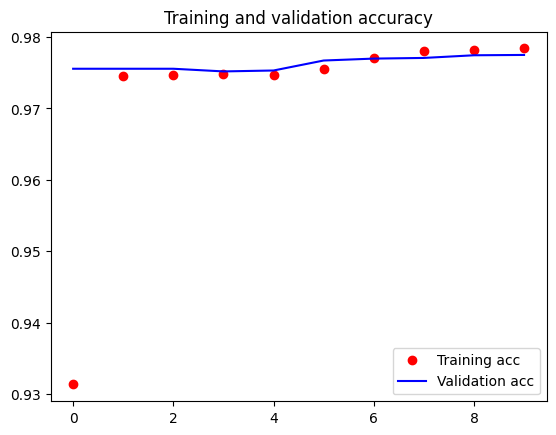

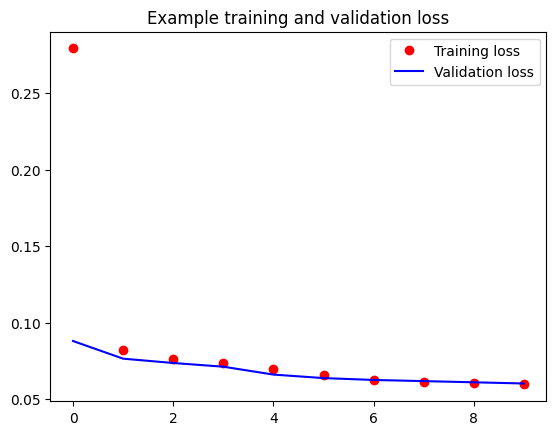

In [19]:
acc = history_model_1['accuracy']
val_acc = history_model_1['val_accuracy']
loss = history_model_1['loss']
val_loss = history_model_1['val_loss']

epochs = range(len(acc))


plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Example training and validation loss')
plt.legend()

plt.show()

## Evaluating model_1

In [20]:
model_1.evaluate(X_test, y_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9795 - auc: 0.9665 - fn: 901.9130 - fp: 74.5217 - loss: 0.0562 - precision: 0.7569 - recall: 0.1942 - tn: 45804.7812 - tp: 215.4783


[0.05761966481804848,
 0.9789409637451172,
 0.739047646522522,
 0.18844099342823029,
 0.964311420917511,
 388.0,
 137.0,
 83658.0,
 1671.0]

##Confusion Matrix

##Predictions

In [26]:
test_predictions = model_1.predict(X_test)
print(test_predictions)

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step
[[0.00070802 0.00351229 0.01585434 ... 0.00109969 0.00100874 0.00459544]
 [0.00070576 0.00350411 0.01582793 ... 0.00109686 0.00100491 0.00458871]
 [0.00070699 0.00350851 0.01584225 ... 0.00109838 0.001007   0.00459239]
 ...
 [0.00070854 0.00351404 0.01586012 ... 0.00110034 0.00100959 0.00459718]
 [0.00070718 0.00350936 0.01584489 ... 0.00109861 0.00100727 0.00459327]
 [0.00070677 0.00350785 0.01583956 ... 0.00109811 0.00100662 0.00459173]]


##Converting predictions to binary

In [22]:
binary_predictions = (test_predictions > 0.5).astype(int)

##Binary labels

In [24]:
def words_to_binary(word_labels, keywords):
  """
  Converts a list of word labels to binary labels.

  Args:
    word_labels: A list of lists, where each inner list contains indices of keywords present in a text.
    keywords: A list of keywords.

  Returns:
    A list of lists, where each inner list contains binary labels (1 if the keyword is present, 0 otherwise).
  """
  binary_labels = []
  for labels in word_labels:
    binary_row = [1 if i in labels else 0 for i in range(len(keywords))]
    binary_labels.append(binary_row)
  return binary_labels

list_of_texts_test = X_test

true_word_labels = create_labels(list_of_texts_test, keywords)  # Assuming you have a list_of_texts_test for test data
true_binary_labels = words_to_binary(true_word_labels, keywords)
true_binary_labels_array = np.array(true_binary_labels)

##Creating confusion matrix

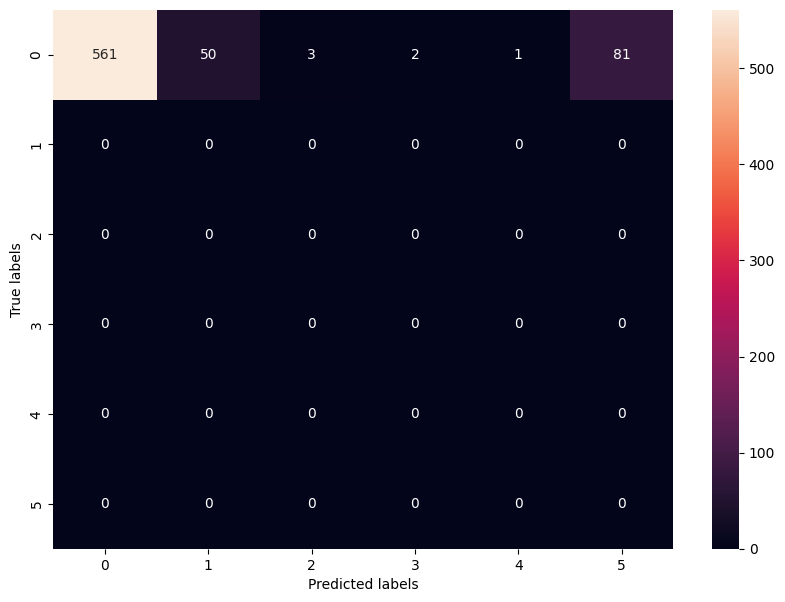

In [25]:
cm = confusion_matrix(true_binary_labels_array.argmax(axis=1), binary_predictions.argmax(axis=1))

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## Changing batch size

###Model 2

In [27]:
model_2 = Sequential([
    Embedding(vocab_size, embedding_dim),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(len(keywords), activation='sigmoid')
])



##Compiling, training and saving the model

In [28]:
#Compiling the model
model_2.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(learning_rate=0.001),
    metrics = METRICS

)

# Convert X_train, X_val, y_train, y_val to numpy arrays if they aren't already
X_train = np.asarray(X_train, dtype=np.float32)
X_val = np.asarray(X_val, dtype=np.float32)
X_test = np.asarray(X_test, dtype=np.float32)
y_train = np.asarray(y_train, dtype=np.float32) # Convert y_train to NumPy array
y_val = np.asarray(y_val, dtype=np.float32)   # Convert y_val to NumPy array
y_test = np.asarray(y_test, dtype=np.float32) # Convert y_test to NumPy array
# Check and potentially adjust the batch size to be consistent
batch_size = 41  # Or a smaller value if memory is an issue
if X_train.shape[0] % batch_size != 0 or X_val.shape[0] % batch_size != 0:
    print("Warning: Batch size does not divide evenly into the number of samples. Consider adjusting the batch size.")

#Training the model
history_model_2 = model_2.fit(
    X_train, y_train,
    validation_data = (X_val, y_val),
    epochs = 10,

)

#Saving the model
model_2.save('model_2.keras')
with open('history_model_2.json', 'w') as f:
    json.dump(history_model_2.history, f)

Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 15s 158ms/step - accuracy: 0.9170 - auc: 0.7390 - fn: 4573.2686 - fp: 12969.9404 - loss: 0.4644 - precision: 0.0677 - recall: 0.1748 - tn: 201089.5938 - tp: 909.3433 - val_accuracy: 0.9756 - val_auc: 0.9150 - val_fn: 1777.0000 - val_fp: 314.0000 - val_loss: 0.0903 - val_precision: 0.5449 - val_recall: 0.1746 - val_tn: 83387.0000 - val_tp: 376.0000
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 0.9749 - auc: 0.9277 - fn: 3045.1045 - fp: 302.6866 - loss: 0.0844 - precision: 0.4595 - recall: 0.0775 - tn: 130063.7734 - tp: 276.5821 - val_accuracy: 0.9749 - val_auc: 0.9401 - val_fn: 2153.0000 - val_fp: 0.0000e+00 - val_loss: 0.0771 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 83701.0000 - val_tp: 0.0000e+00
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 0.9763 - auc: 0.9425 - fn: 2848.4031 - fp: 462.9403 - loss: 0.0741 - precision: 0.4919 - recall: 0.1378 - tn: 129886.5234 - tp: 490.2836 - val_accurac

In [29]:
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 1000, 128)           │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 1000, 128)           │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 123)                 │           7,995 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,284,083 (16.34 MB)

 Trainable params: 1,428,027 (5.45 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,856,056 (10.89 MB)

##Reloading the model

In [30]:
model_2 = tf.keras.models.load_model('model_2.keras')
with open('history_model_2.json') as f:
    history_model_2 = json.load(f)

##Plotting the training history

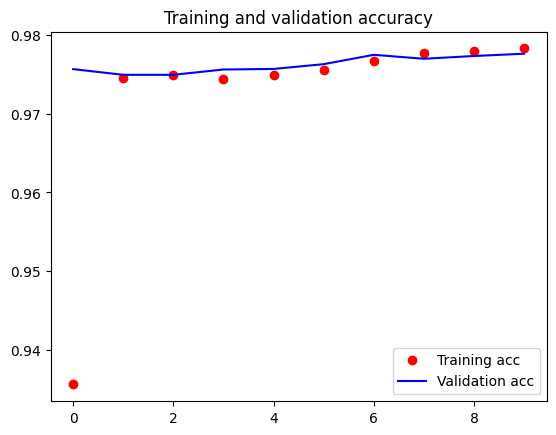

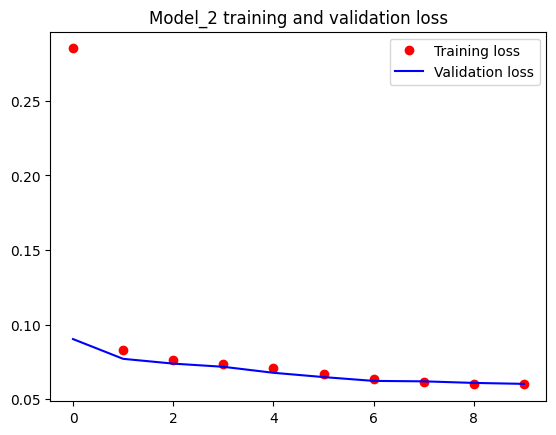

In [31]:
acc = history_model_2['accuracy']
val_acc = history_model_2['val_accuracy']
loss = history_model_2['loss']
val_loss = history_model_2['val_loss']

epochs = range(len(acc))


plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Model_2 training and validation loss')
plt.legend()

plt.show()

##Evaluting the model

In [32]:
model_2.evaluate(X_test, y_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9795 - auc: 0.9661 - fn: 933.1739 - fp: 45.7391 - loss: 0.0562 - precision: 0.8103 - recall: 0.1700 - tn: 45833.5664 - tp: 184.2174


[0.057791899889707565,
 0.9788594245910645,
 0.7946860194206238,
 0.15978629887104034,
 0.9638016819953918,
 329.0,
 85.0,
 83710.0,
 1730.0]

##Predictions

In [39]:
test_predictions = model_2.predict(X_test)
print(test_predictions)


22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 208ms/step
[[0.00095464 0.0057129  0.01492035 ... 0.00058209 0.00052443 0.00343615]
 [0.0009529  0.0057073  0.01490925 ... 0.00058084 0.00052365 0.00343269]
 [0.00095333 0.00570868 0.01491201 ... 0.00058118 0.00052385 0.00343357]
 ...
 [0.00095546 0.00571563 0.01492564 ... 0.00058267 0.0005248  0.00343779]
 [0.00095402 0.00571098 0.01491673 ... 0.00058166 0.00052416 0.00343488]
 [0.00095399 0.00571079 0.01491607 ... 0.00058163 0.00052414 0.00343482]]


#Reduce number of LSTM modules

##Model 3

In [36]:
model_3 = Sequential([
    Embedding(vocab_size, embedding_dim),
    Bidirectional(LSTM(32, return_sequences=True)),
    Bidirectional(LSTM(16)),
    Dense(len(keywords), activation='sigmoid')
])



##Compiling, training and saving the model

In [37]:
#Compiling the model
model_3.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(learning_rate=0.001),
    metrics = METRICS

)

# Convert X_train, X_val, y_train, y_val to numpy arrays if they aren't already
X_train = np.asarray(X_train, dtype=np.float32)
X_val = np.asarray(X_val, dtype=np.float32)
X_test = np.asarray(X_test, dtype=np.float32)
y_train = np.asarray(y_train, dtype=np.float32) # Convert y_train to NumPy array
y_val = np.asarray(y_val, dtype=np.float32)   # Convert y_val to NumPy array
y_test = np.asarray(y_test, dtype=np.float32) # Convert y_test to NumPy array
# Check and potentially adjust the batch size to be consistent
batch_size = 17  # Or a smaller value if memory is an issue
if X_train.shape[0] % batch_size != 0 or X_val.shape[0] % batch_size != 0:
    print("Warning: Batch size does not divide evenly into the number of samples. Consider adjusting the batch size.")

#Training the model
history_model_3 = model_3.fit(
    X_train, y_train,
    validation_data = (X_val, y_val),
    epochs = 10,

)

#Saving the model
model_3.save('model_3.keras')
with open('history_model_3.json', 'w') as f:
    json.dump(history_model_3.history, f)

Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 0.8773 - auc: 0.7088 - fn: 4297.4326 - fp: 22320.0449 - loss: 0.5507 - precision: 0.0554 - recall: 0.2309 - tn: 191668.4688 - tp: 1256.2090 - val_accuracy: 0.9749 - val_auc: 0.7622 - val_fn: 2153.0000 - val_fp: 0.0000e+00 - val_loss: 0.1632 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 83701.0000 - val_tp: 0.0000e+00
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 0.9743 - auc: 0.8055 - fn: 3138.4775 - fp: 321.4925 - loss: 0.1391 - precision: 0.3928 - recall: 0.0692 - tn: 129919.8672 - tp: 308.3134 - val_accuracy: 0.9749 - val_auc: 0.9060 - val_fn: 2153.0000 - val_fp: 0.0000e+00 - val_loss: 0.0993 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 83701.0000 - val_tp: 0.0000e+00
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 0.9732 - auc: 0.9043 - fn: 3268.1045 - fp: 220.1492 - loss: 0.0996 - precision: 0.3712 - recall: 0.0475 - tn: 129991.4766 - tp: 208.4179

In [38]:
model_3.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 1000, 128)           │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 1000, 64)            │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 32)                  │          10,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 123)                 │           4,059 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,006,931 (15.29 MB)

 Trainable params: 1,335,643 (5.10 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,671,288 (10.19 MB)

##Reloading the model

In [40]:
model_3 = tf.keras.models.load_model('model_3.keras')
with open('history_model_3.json') as f:
    history_model_3 = json.load(f)

##Plotting the training history

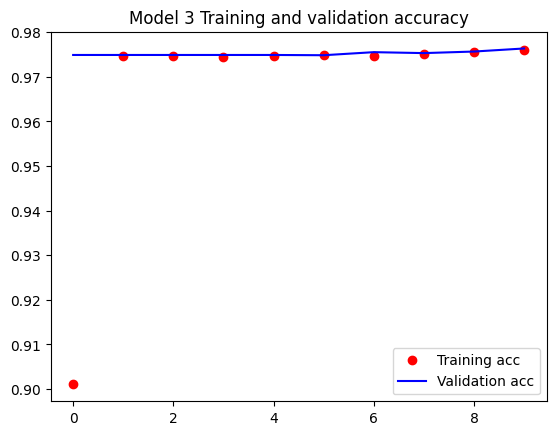

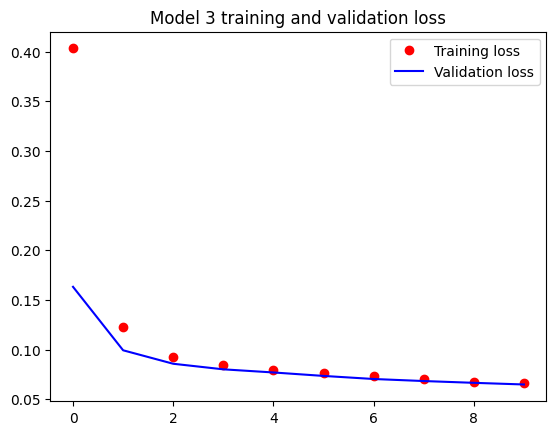

In [41]:
acc = history_model_3['accuracy']
val_acc = history_model_3['val_accuracy']
loss = history_model_3['loss']
val_loss = history_model_3['val_loss']

epochs = range(len(acc))


plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Model 3 Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Model 3 training and validation loss')
plt.legend()

plt.show()

##Evaluating the model

In [42]:
model_3.evaluate(X_test, y_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9780 - auc: 0.9641 - fn: 1037.3043 - fp: 9.0435 - loss: 0.0612 - precision: 0.9017 - recall: 0.0724 - tn: 45870.2617 - tp: 80.0870


[0.06247222051024437,
 0.9775083661079407,
 0.895061731338501,
 0.07042253762483597,
 0.9625352621078491,
 145.0,
 17.0,
 83778.0,
 1914.0]

##Predictions

In [43]:
test_predictions = model_3.predict(X_test)
print(test_predictions)

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step
[[0.00117885 0.00757736 0.01499947 ... 0.00367328 0.00107085 0.00912986]
 [0.0011721  0.00754821 0.01494848 ... 0.00365508 0.00106423 0.00911259]
 [0.00117208 0.00754813 0.01494838 ... 0.00365507 0.00106421 0.00911264]
 ...
 [0.00118207 0.00759123 0.0150239  ... 0.00368192 0.001074   0.00913784]
 [0.00118097 0.00758647 0.01501566 ... 0.00367891 0.00107288 0.00913491]
 [0.00117676 0.00756843 0.0149839  ... 0.00366764 0.0010688  0.00912443]]


#Increasing batch size

##Model 4


In [44]:
model_4 = Sequential([
    Embedding(vocab_size, embedding_dim),
    Bidirectional(LSTM(32, return_sequences=True)),
    Bidirectional(LSTM(16)),
    Dense(len(keywords), activation='sigmoid')
])

##Compiling, training and saving the model

In [45]:
#Compiling the model
model_4.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(learning_rate=0.001),
    metrics = METRICS

)

# Convert X_train, X_val, y_train, y_val to numpy arrays if they aren't already
X_train = np.asarray(X_train, dtype=np.float32)
X_val = np.asarray(X_val, dtype=np.float32)
X_test = np.asarray(X_test, dtype=np.float32)
y_train = np.asarray(y_train, dtype=np.float32) # Convert y_train to NumPy array
y_val = np.asarray(y_val, dtype=np.float32)   # Convert y_val to NumPy array
y_test = np.asarray(y_test, dtype=np.float32) # Convert y_test to NumPy array
# Check and potentially adjust the batch size to be consistent
batch_size = 41  # Or a smaller value if memory is an issue
if X_train.shape[0] % batch_size != 0 or X_val.shape[0] % batch_size != 0:
    print("Warning: Batch size does not divide evenly into the number of samples. Consider adjusting the batch size.")

#Training the model
history_model_4 = model_4.fit(
    X_train, y_train,
    validation_data = (X_val, y_val),
    epochs = 10,

)

#Saving the model
model_4.save('model_4.keras')
with open('history_model_4.json', 'w') as f:
    json.dump(history_model_4.history, f)

model_4.summary()

Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 15s 153ms/step - accuracy: 0.9004 - auc: 0.6848 - fn: 4754.8359 - fp: 16602.0898 - loss: 0.5540 - precision: 0.0412 - recall: 0.1295 - tn: 197496.8125 - tp: 688.4179 - val_accuracy: 0.9756 - val_auc: 0.8254 - val_fn: 1777.0000 - val_fp: 322.0000 - val_loss: 0.1557 - val_precision: 0.5387 - val_recall: 0.1746 - val_tn: 83379.0000 - val_tp: 376.0000
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 0.9745 - auc: 0.8522 - fn: 3067.2986 - fp: 339.9851 - loss: 0.1327 - precision: 0.5066 - recall: 0.1112 - tn: 129925.7734 - tp: 355.0895 - val_accuracy: 0.9749 - val_auc: 0.9227 - val_fn: 2153.0000 - val_fp: 0.0000e+00 - val_loss: 0.0962 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 83701.0000 - val_tp: 0.0000e+00
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 0.9733 - auc: 0.9234 - fn: 3395.6418 - fp: 63.8806 - loss: 0.0966 - precision: 0.2621 - recall: 0.0123 - tn: 130156.4141 - tp: 72.2090 - val_accuracy: 

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 1000, 128)           │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 1000, 64)            │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 32)                  │          10,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 123)                 │           4,059 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,006,931 (15.29 MB)

 Trainable params: 1,335,643 (5.10 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,671,288 (10.19 MB)

##Reloading the model

In [46]:
model_4 = tf.keras.models.load_model('model_4.keras')
with open('history_model_4.json') as f:
    history_model_4 = json.load(f)

##Plotting the training history

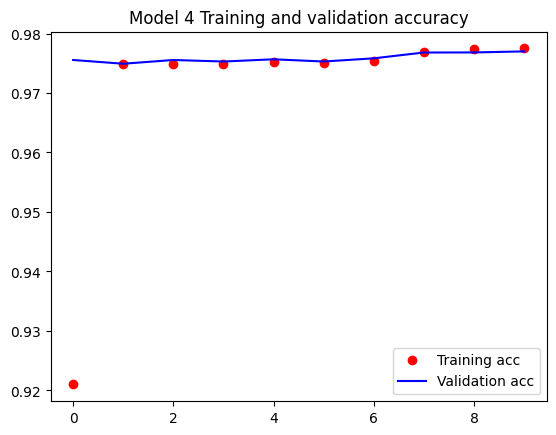

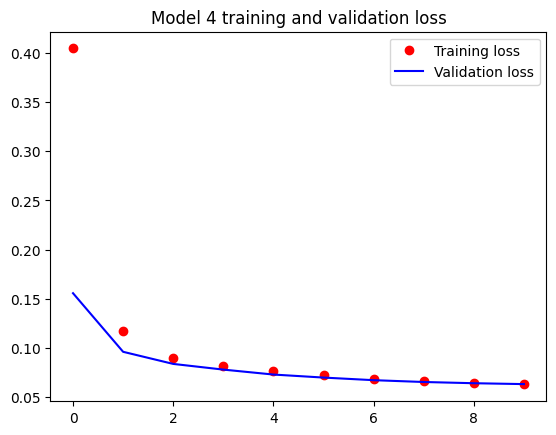

In [47]:
acc = history_model_4['accuracy']
val_acc = history_model_4['val_accuracy']
loss = history_model_4['loss']
val_loss = history_model_4['val_loss']

epochs = range(len(acc))


plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Model 4 Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Model 4 training and validation loss')
plt.legend()

plt.show()

##Evaluating the model

In [48]:
model_4.evaluate(X_test, y_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9790 - auc: 0.9652 - fn: 981.3043 - fp: 21.3043 - loss: 0.0590 - precision: 0.8760 - recall: 0.1260 - tn: 45858.0000 - tp: 136.0870


[0.0606025829911232,
 0.9784052968025208,
 0.8621907830238342,
 0.1185041293501854,
 0.9630874395370483,
 244.0,
 39.0,
 83756.0,
 1815.0]

##Predictions

In [49]:
test_predictions = model_4.predict(X_test)
print(test_predictions)

22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 192ms/step
[[0.00421722 0.00693573 0.01583409 ... 0.0040943  0.00448798 0.00679206]
 [0.00418998 0.00688985 0.0157587  ... 0.00407    0.00446043 0.00676515]
 [0.00419159 0.00689274 0.01576252 ... 0.00407147 0.00446195 0.00676693]
 ...
 [0.00422496 0.00694891 0.01585571 ... 0.00410113 0.0044957  0.00679972]
 [0.00421648 0.00693448 0.01583262 ... 0.00409379 0.00448714 0.00679163]
 [0.00420122 0.00690885 0.01578994 ... 0.00408003 0.00447177 0.00677628]]


##Comparing the four models

In [50]:
model_1.evaluate(X_test, y_test)
model_2.evaluate(X_test, y_test)
model_3.evaluate(X_test, y_test)
model_4.evaluate(X_test, y_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9795 - auc: 0.9665 - fn: 901.9130 - fp: 74.5217 - loss: 0.0562 - precision: 0.7569 - recall: 0.1942 - tn: 45804.7812 - tp: 215.4783
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9795 - auc: 0.9661 - fn: 933.1739 - fp: 45.7391 - loss: 0.0562 - precision: 0.8103 - recall: 0.1700 - tn: 45833.5664 - tp: 184.2174
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9780 - auc: 0.9641 - fn: 1037.3043 - fp: 9.0435 - loss: 0.0612 - precision: 0.9017 - recall: 0.0724 - tn: 45870.2617 - tp: 80.0870
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.9790 - auc: 0.9652 - fn: 981.3043 - fp: 21.3043 - loss: 0.0590 - precision: 0.8760 - recall: 0.1260 - tn: 45858.0000 - tp: 136.0870


[0.0606025829911232,
 0.9784052968025208,
 0.8621907830238342,
 0.1185041293501854,
 0.9630874395370483,
 244.0,
 39.0,
 83756.0,
 1815.0]

As can be see from the above the four models all perform very similarly however the more complex models of 1 and 2 have better loss functions.

For the next model I will change the loss function from binary crossentropy to hinge loss.
This should result encourage the model to not only make correct predictions but also be confident in those predictions

##Model 5

In [51]:
model_5 = Sequential([
    Embedding(vocab_size, embedding_dim),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(len(keywords), activation='sigmoid')
])

##Compiling, training and saving the model

In [52]:
#Compiling the model
model_5.compile(
    loss = 'hinge',
    optimizer = 'adam',
    metrics = METRICS

)

# Convert X_train, X_val, y_train, y_val to numpy arrays if they aren't already
X_train = np.asarray(X_train, dtype=np.float32)
X_val = np.asarray(X_val, dtype=np.float32)
X_test = np.asarray(X_test, dtype=np.float32)
y_train = np.asarray(y_train, dtype=np.float32) # Convert y_train to NumPy array
y_val = np.asarray(y_val, dtype=np.float32)   # Convert y_val to NumPy array
y_test = np.asarray(y_test, dtype=np.float32) # Convert y_test to NumPy array
# Check and potentially adjust the batch size to be consistent
batch_size = 41  # Or a smaller value if memory is an issue
if X_train.shape[0] % batch_size != 0 or X_val.shape[0] % batch_size != 0:
    print("Warning: Batch size does not divide evenly into the number of samples. Consider adjusting the batch size.")

#Training the model
history_model_5 = model_5.fit(
    X_train, y_train,
    validation_data = (X_val, y_val),
    epochs = 10,

)

#Saving the model
model_5.save('model_5.keras')
with open('history_model_5.json', 'w') as f:
    json.dump(history_model_5.history, f)

Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 148ms/step - accuracy: 0.9053 - auc: 0.7229 - fn: 4188.1494 - fp: 15983.8955 - loss: 1.3316 - precision: 0.0735 - recall: 0.2317 - tn: 198101.5312 - tp: 1268.5671 - val_accuracy: 0.9756 - val_auc: 0.6422 - val_fn: 1777.0000 - val_fp: 322.0000 - val_loss: 1.0210 - val_precision: 0.5387 - val_recall: 0.1746 - val_tn: 83379.0000 - val_tp: 376.0000
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 18s 142ms/step - accuracy: 0.9744 - auc: 0.6480 - fn: 2859.5522 - fp: 551.9850 - loss: 1.0155 - precision: 0.4844 - recall: 0.1552 - tn: 129741.7031 - tp: 534.9105 - val_accuracy: 0.9756 - val_auc: 0.6752 - val_fn: 1777.0000 - val_fp: 322.0000 - val_loss: 1.0065 - val_precision: 0.5387 - val_recall: 0.1746 - val_tn: 83379.0000 - val_tp: 376.0000
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 0.9755 - auc: 0.6567 - fn: 2795.9553 - fp: 552.5074 - loss: 1.0063 - precision: 0.4761 - recall: 0.1603 - tn: 129805.2969 - tp: 534.3881 - val_accuracy: 0.9756 

In [53]:
model_5.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 1000, 128)           │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ (None, 1000, 128)           │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 123)                 │           7,995 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,284,083 (16.34 MB)

 Trainable params: 1,428,027 (5.45 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,856,056 (10.89 MB)

##Reloading the model

In [54]:
model_5 = tf.keras.models.load_model('model_5.keras')
with open('history_model_5.json') as f:
    history_model_5 = json.load(f)

##Plotting the training

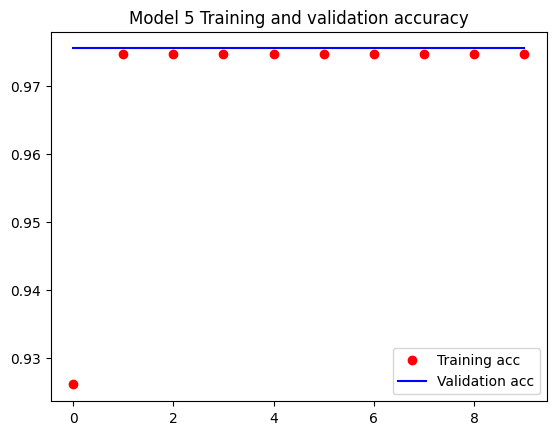

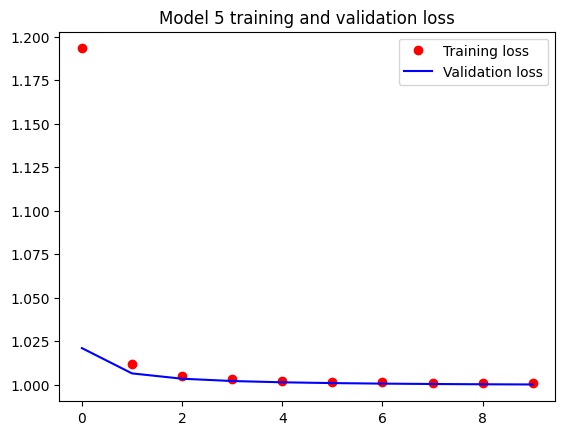

In [55]:
acc = history_model_5['accuracy']
val_acc = history_model_5['val_accuracy']
loss = history_model_5['loss']
val_loss = history_model_5['val_loss']

epochs = range(len(acc))


plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Model 5 Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Model 5 training and validation loss')
plt.legend()

plt.show()

##Evaluating the model

In [56]:
model_5.evaluate(X_test, y_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.9764 - auc: 0.5832 - fn: 923.9130 - fp: 188.6087 - loss: 1.0007 - precision: 0.4943 - recall: 0.1707 - tn: 45690.6953 - tp: 193.4783


[1.0004503726959229,
 0.9762505292892456,
 0.5143266320228577,
 0.17435649037361145,
 0.5851554274559021,
 359.0,
 339.0,
 83456.0,
 1700.0]

##Predictions

In [64]:
test_predictions = model_5.predict(X_test)
print(test_predictions)

22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step
[[0.00068749 0.00063449 0.00098539 ... 0.0010017  0.00037826 0.0005685 ]
 [0.00068651 0.0006335  0.00098398 ... 0.0010005  0.0003778  0.00056761]
 [0.00068604 0.00063302 0.00098331 ... 0.0009999  0.00037758 0.00056717]
 ...
 [0.00068769 0.00063469 0.00098575 ... 0.00100196 0.00037837 0.0005687 ]
 [0.00068746 0.00063445 0.00098536 ... 0.00100169 0.00037825 0.00056849]
 [0.00068692 0.00063392 0.00098459 ... 0.00100099 0.00037799 0.00056798]]


##Model 6 - training for 20 epochs

In [59]:
model_6 = Sequential([
    Embedding(vocab_size, embedding_dim),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(len(keywords), activation='sigmoid')
])

##Compiling, training and saving the model

In [61]:
#Compiling the model
model_6.compile(
    loss = 'hinge',
    optimizer = 'adam',
    metrics = METRICS

)

# Convert X_train, X_val, y_train, y_val to numpy arrays if they aren't already
X_train = np.asarray(X_train, dtype=np.float32)
X_val = np.asarray(X_val, dtype=np.float32)
X_test = np.asarray(X_test, dtype=np.float32)
y_train = np.asarray(y_train, dtype=np.float32) # Convert y_train to NumPy array
y_val = np.asarray(y_val, dtype=np.float32)   # Convert y_val to NumPy array
y_test = np.asarray(y_test, dtype=np.float32) # Convert y_test to NumPy array
# Check and potentially adjust the batch size to be consistent
batch_size = 41  # Or a smaller value if memory is an issue
if X_train.shape[0] % batch_size != 0 or X_val.shape[0] % batch_size != 0:
    print("Warning: Batch size does not divide evenly into the number of samples. Consider adjusting the batch size.")

#Training the model
history_model_6 = model_6.fit(
    X_train, y_train,
    validation_data = (X_val, y_val),
    epochs = 20,

)

#Saving the model
model_6.save('model_6.keras')
with open('history_model_6.json', 'w') as f:
    json.dump(history_model_6.history, f)

model_6.summary()

Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 15s 150ms/step - accuracy: 0.9243 - auc: 0.5723 - fn: 7119.9551 - fp: 16001.8213 - loss: 1.1053 - precision: 0.0528 - recall: 0.1186 - tn: 293927.6875 - tp: 892.6866 - val_accuracy: 0.9749 - val_auc: 0.6131 - val_fn: 2153.0000 - val_fp: 0.0000e+00 - val_loss: 1.0124 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 83701.0000 - val_tp: 0.0000e+00
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 0.9742 - auc: 0.6216 - fn: 3415.8955 - fp: 0.0000e+00 - loss: 1.0098 - precision: 0.0000e+00 - recall: 0.0000e+00 - tn: 130272.2500 - tp: 0.0000e+00 - val_accuracy: 0.9749 - val_auc: 0.6302 - val_fn: 2153.0000 - val_fp: 0.0000e+00 - val_loss: 1.0049 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 83701.0000 - val_tp: 0.0000e+00
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 11s 160ms/step - accuracy: 0.9750 - auc: 0.5991 - fn: 3387.0747 - fp: 0.0000e+00 - loss: 1.0045 - precision: 0.0000e+00 - recall: 0.0000e+00 - tn: 130301

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ (None, 1000, 128)           │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_10 (Bidirectional)     │ (None, 1000, 128)           │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_11 (Bidirectional)     │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 123)                 │           7,995 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,284,083 (16.34 MB)

 Trainable params: 1,428,027 (5.45 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,856,056 (10.89 MB)

##Reloading the model

In [62]:
model_6 = tf.keras.models.load_model('model_6.keras')
with open('history_model_6.json') as f:
    history_model_6 = json.load(f)

##Training plots

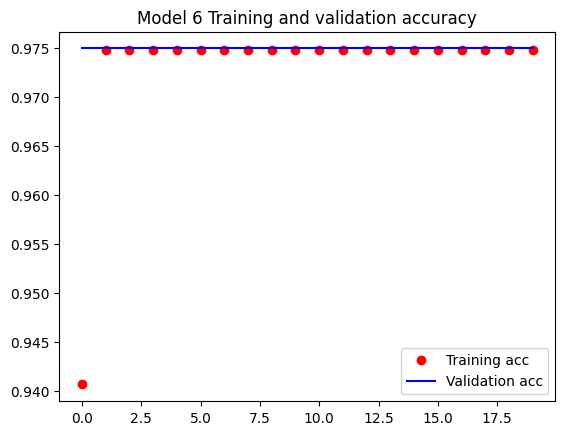

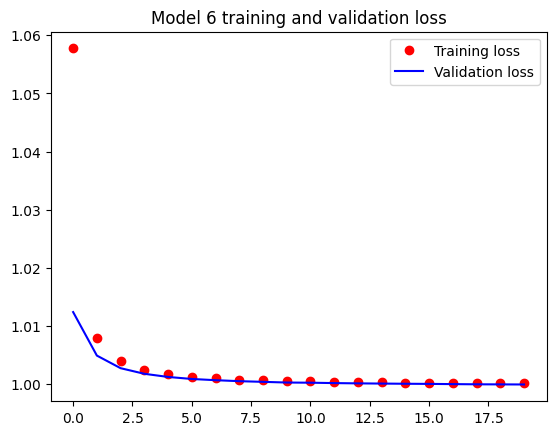

In [63]:
acc = history_model_6['accuracy']
val_acc = history_model_6['val_accuracy']
loss = history_model_6['loss']
val_loss = history_model_6['val_loss']

epochs = range(len(acc))


plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Model 6 Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Model 6 training and validation loss')
plt.legend()

plt.show()

##Predictions

In [65]:
test_predictions = model_6.predict(X_test)
print(test_predictions)

22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step
[[6.36738041e-05 2.45200383e-04 1.19311764e-04 ... 1.51677115e-04
  1.47490398e-04 4.58955124e-04]
 [6.32444571e-05 2.43241433e-04 1.18368363e-04 ... 1.50324820e-04
  1.46512015e-04 4.56071954e-04]
 [6.31823059e-05 2.42958413e-04 1.18233118e-04 ... 1.50127860e-04
  1.46367631e-04 4.55647649e-04]
 ...
 [6.37594858e-05 2.45594420e-04 1.19498487e-04 ... 1.51944769e-04
  1.47682906e-04 4.59531235e-04]
 [6.37179692e-05 2.45402713e-04 1.19407021e-04 ... 1.51814849e-04
  1.47590283e-04 4.59259289e-04]
 [6.34516546e-05 2.44188792e-04 1.18826269e-04 ... 1.50976717e-04
  1.46983715e-04 4.57473972e-04]]


##Evaluating the model

In [66]:
model_6.evaluate(X_test, y_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.9765 - auc: 0.5833 - fn: 1117.3914 - fp: 0.0000e+00 - loss: 1.0002 - precision: 0.0000e+00 - recall: 0.0000e+00 - tn: 45879.3047 - tp: 0.0000e+00


[1.0000890493392944,
 0.9760174751281738,
 0.0,
 0.0,
 0.585196316242218,
 0.0,
 0.0,
 83795.0,
 2059.0]

Accuracy of models 5 and 6 similiar to all other models

##Model 7 Changing loss function to categorical crossentropy

In [1]:
!pip install scikit-learn==1.2.2
from sklearn.preprocessing import OneHotEncoder

# Initialize the encoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Reshape your labels to be 2D (required by OneHotEncoder)
y_train_reshaped = np.array(y_train).reshape(-1, 1)

# Fit and transform your labels
y_train_encoded = encoder.fit_transform(y_train_reshaped)

# Repeat the process for y_val and y_test
y_val_reshaped = np.array(y_val).reshape(-1, 1)
y_val_encoded = encoder.transform(y_val_reshaped)

y_test_reshaped = np.array(y_test).reshape(-1, 1)
y_test_encoded = encoder.transform(y_test_reshaped)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 21.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2


NameError: name 'np' is not defined